In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from numpy.linalg import inv
from collections import OrderedDict
from operator import itemgetter
import string
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import time
import cv2 
import cv2 as cv

In [40]:
def loadData():
    start_time = time.time()
    print 'start...'
    URL_ENDPOINT = "http://cs.mcgill.ca/~ksinha4/datasets/kaggle/"
    x = np.loadtxt(URL_ENDPOINT+"train_x.csv", delimiter=",")
    y = np.loadtxt(URL_ENDPOINT+"train_y.csv", delimiter=",")
    test_y = np.loadtxt(URL_ENDPOINT+"test_x.csv", delimiter=",")
    x = x.reshape(-1, 64, 64) # reshape 
    y = y.reshape(-1, 1) 
    print("Loaded data in --- %s seconds ---" % (time.time() - start_time))
    return [x,y,test_y]
x,y,xTest = loadData()


#img = cv2.imread('maxresdefault.jpg',0)


start...
Loaded data in --- 55.8828229904 seconds ---


In [51]:
x    = x.reshape(-1, 64, 64)
xTest = xTest.reshape(-1,64,64)
print x.shape
print xTest.shape

(50000, 64, 64)
(10000, 64, 64)


## Showing preprocessing resutls

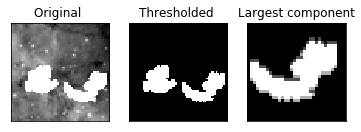

[3.]


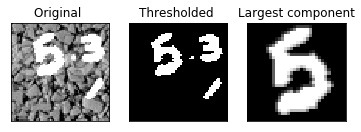

[5.]


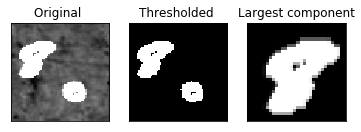

[8.]


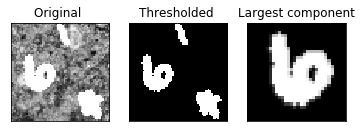

[6.]


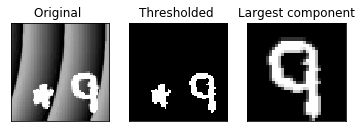

[9.]


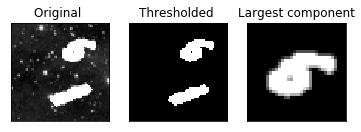

[1.]


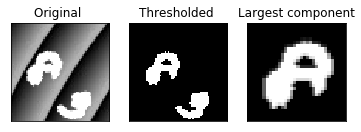

[8.]


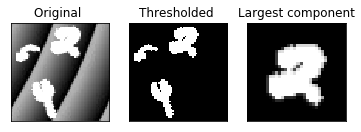

[4.]


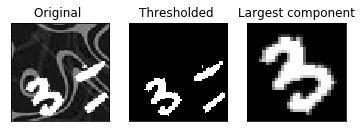

[3.]


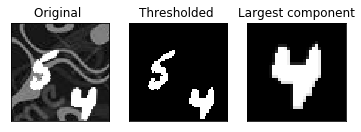

[5.]


In [59]:
def presentPreProc():
    for i in range (1000,1010):
        index = i
        img = x[index].astype('uint8')
        image = np.zeros((64,64),dtype='uint8')
        image[img==255] = 255 

        def showContours(thresh):
            nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)
            sizes = stats[:, -1]
            max_label = 1
            max_size = sizes[1]
            for i in range(2, nb_components):
                if sizes[i] > max_size:
                    max_label = i
                    max_size = sizes[i]
            img2 = np.zeros(output.shape)
            img2[output == max_label] = 255.
            tx = 32 - centroids[max_label][0];
            ty = 32 - centroids[max_label][1];
            M = np.float32([[1,0,tx],[0,1,ty]])
            dst = cv.warpAffine(img2,M,(64,64))
            #print "centroids = \n",centroids
            #print dst[16:48,16:48].shape
            return dst[16:48,16:48]
    
        plt.subplot(131),plt.imshow(img,cmap = 'gray')
        plt.title('Original '), plt.xticks([]), plt.yticks([]);
        plt.subplot(132),plt.imshow(image,cmap = 'gray')
        plt.title('Thresholded '), plt.xticks([]), plt.yticks([]);
        #plt.hist(image.ravel(),256,[0,256]); plt.show()
        plt.subplot(133),plt.imshow(showContours(image),cmap = 'gray');
        plt.title('Largest component'), plt.xticks([]), plt.yticks([]);
        plt.show();
        print y[i]

presentPreProc();

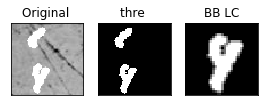

True y= [4.]


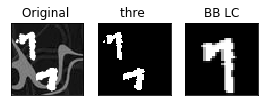

True y= [7.]


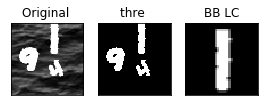

True y= [1.]


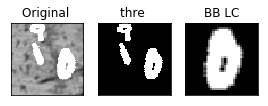

True y= [0.]


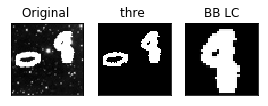

True y= [8.]


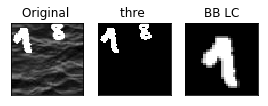

True y= [7.]


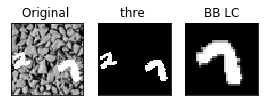

True y= [7.]


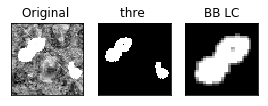

True y= [8.]


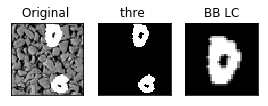

True y= [0.]


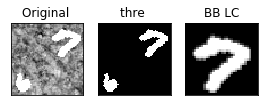

True y= [7.]


In [200]:
def binary_tresholding(img):
        image = np.zeros((64,64),dtype='uint8')
        image[img==255] = 255 
        return image;
    
def BBLargest(image):
    thresh = binary_tresholding(image)
    thresh = thresh.astype('uint8')

    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    Ws = [] 
    Hs = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        Ws.append(w)
        Hs.append(h)
    max_h = max(Hs)
    max_w = max(Ws)
    max_l = max(max_h,max_w)
    
    # Find the index of the contour with largest width
    if max_l == max_h:
        max_index = np.argmax(Hs)
    else:
        max_index = np.argmax(Ws)
    #print "max_index = ",max_index
    x,y,w,h = cv2.boundingRect(contours[max_index])

    #to create a filter to remove all other digits and keep just the biggest one
    filter_ = np.zeros(image.shape)
    filter_ = cv2.rectangle(filter_,(x,y),(x+max_l,y+max_l),(255,255,255),-1)
    
    #find center of the component
    px = x+max_l/2
    py = y+max_l/2
    
    tx = 32 - px;
    ty = 32 - py;
    
    M = np.float32([[1,0,tx],[0,1,ty]])
    dst = cv.warpAffine(im2,M,(64,64))
    
    #plt.subplot(142)
    #plt.imshow(filter_,'gray')
    #plt.title('Filter image')

    preprocessed_img = np.zeros(im2.shape)
    preprocessed_img = thresh*filter_
    
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)
    countMax =0;
    countMaxIndex=0;
    for i in range( nb_components):
        img2 = np.zeros(output.shape)
        img2[output == i] = 255.
        img3 = np.zeros(output.shape)
        img3 = img2 [img2 == preprocessed_img] 
        countTemp = np.count_nonzero(img3 )
        if countTemp > countMax :
            countMax = countTemp
            countMaxIndex =i;
    
    img2 = np.zeros(output.shape)
    img2[output == countMaxIndex] = 255.
    tx = 32 - centroids[countMaxIndex][0];
    ty = 32 - centroids[countMaxIndex][1];
    M = np.float32([[1,0,tx],[0,1,ty]])
    dst = cv.warpAffine(img2,M,(64,64))
    
    #plt.subplot(143)
    #plt.imshow(preprocessed_img,'gray')
    #plt.title('BBB')

    #plt.subplot(144)
    #plt.imshow(dst,'gray')
    #plt.title('dst image')
    
    #return preprocessed_img
    return dst

#################################3
def showContours(thresh):
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)
    sizes = stats[:, -1]
    max_label = 1
    max_size = sizes[1]
    for i in range(1, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255.
    tx = 32 - centroids[max_label][0];
    ty = 32 - centroids[max_label][1];
    M = np.float32([[1,0,tx],[0,1,ty]])
    dst = cv.warpAffine(img2,M,(64,64))
    #print "centroids = \n",centroids
    #print dst[16:48,16:48].shape
    return dst[16:48,16:48]
    
def presentPreProcBB(x,index,steps):
    for i in range (index,index+steps):
        index = i
        img = x[index].astype('uint8')
        image = np.zeros((64,64),dtype='uint8')
        image[img==255] = 255 
    
        plt.subplot(141),plt.imshow(img,cmap = 'gray')
        plt.title('Original '), plt.xticks([]), plt.yticks([]);
        plt.subplot(142),plt.imshow(image,cmap = 'gray')
        plt.title('thre '), plt.xticks([]), plt.yticks([]);
        #plt.hist(image.ravel(),256,[0,256]); plt.show()
        #plt.subplot(143),plt.imshow(showContours(image),cmap = 'gray');
        #plt.title('LC'), plt.xticks([]), plt.yticks([]);
        plt.subplot(143),plt.imshow(BBLargest(img)[16:48,16:48],cmap = 'gray');
        plt.title('BB LC'), plt.xticks([]), plt.yticks([]);
        plt.show();
        #showLargestBB(image)
        print 'True y=',y[i]

presentPreProcBB(x,0,10);
#presentPreProcBB(xTest,0,10);

## Saving some sample images

In [8]:
def saveSampleDataSetImages(x):
    for i in range(100):
        cv2.imwrite('images/%d.jpg'%(i+1),x[i])
    print 'Done...'
saveSampleDataSetImages(x)

Done...


In [9]:
from sys import getsizeof
def getSizeX(a):
    print a.size * a.dtype.itemsize * 1e-9

getSizeX(x);

1.6384


In [42]:
def returnBiggestContour(image):
    thresh = np.array(image,dtype='uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)
    sizes = stats[:, -1]
    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255.
    tx = 32 - centroids[max_label][0];
    ty = 32 - centroids[max_label][1];
    M = np.float32([[1,0,tx],[0,1,ty]])
    dst = cv.warpAffine(img2,M,(64,64))
    return dst

def compareDatasets(x,xProcessed):
    for i in range(x.shape[0]):
        plt.subplot(131),plt.imshow(x[i],cmap = 'gray')
        plt.title('Original Image'), plt.xticks([]), plt.yticks([]);
        plt.subplot(132),plt.imshow(xProcessed[i],cmap = 'gray')
        plt.title('Processed Image'), plt.xticks([]), plt.yticks([]);
        plt.show();

        

def preProcessData(x):
    start_time = time.time()
    xProcessed = np.zeros(x.shape)
    xProcessed[x==255] = 255 
    for i in range(xProcessed.shape[0]):
        xProcessed[i] = returnBiggestContour(xProcessed[i])
    print("--- %s seconds ---" % (time.time() - start_time))
    return xProcessed[:,16:48,16:48];

#xP     = preProcessData(x)
#xPTest = preProcessData(xTest.reshape(-1,64,64))
#compareDatasets(x[:3],xP[:3])
getSizeX(xP);
getSizeX(xPTest);


--- 1.06696295738 seconds ---
0.08192


# Final Datapreprocessing

In [183]:
def preProcessDataFinal(x):
    start_time = time.time()
    xProcessed = np.zeros(x.shape)
    xProcessed[x==255] = 255 
    for i in range(xProcessed.shape[0]):
        xProcessed[i] = BBLargest(xProcessed[i])
    print("--- %s seconds ---" % (time.time() - start_time))
    return xProcessed[:,16:48,16:48];

xP_BB     = preProcessDataFinal(x)
xPTest_BB = preProcessDataFinal(xTest.reshape(-1,64,64))


--- 14.2063798904 seconds ---
--- 2.77812814713 seconds ---


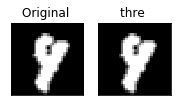

True y= [4.]


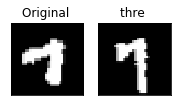

True y= [7.]


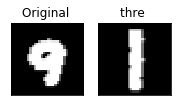

True y= [1.]


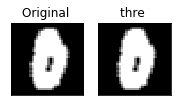

True y= [0.]


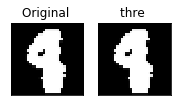

True y= [8.]


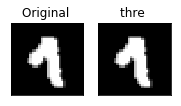

True y= [7.]


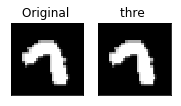

True y= [7.]


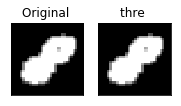

True y= [8.]


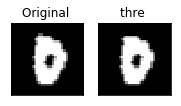

True y= [0.]


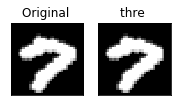

True y= [7.]


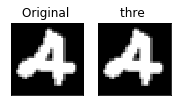

True y= [4.]


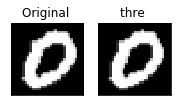

True y= [0.]


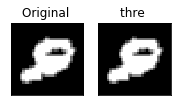

True y= [9.]


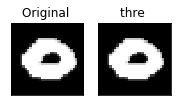

True y= [0.]


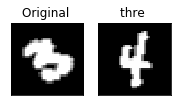

True y= [4.]


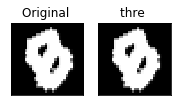

True y= [8.]


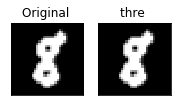

True y= [8.]


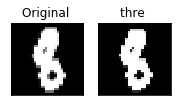

True y= [8.]


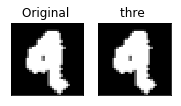

True y= [9.]


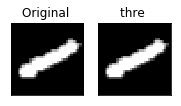

True y= [1.]


In [197]:
def compareDSs(x,xx,index,steps):
    for i in range (index,index+steps):
        plt.subplot(141),plt.imshow(x[i],cmap = 'gray')
        plt.title('Original '), plt.xticks([]), plt.yticks([]);
        plt.subplot(142),plt.imshow(xx[i],cmap = 'gray')
        plt.title('thre '), plt.xticks([]), plt.yticks([]);
        #plt.hist(image.ravel(),256,[0,256]); plt.show()
        plt.show();
        #showLargestBB(image)
        print 'True y=',y[i]

compareDSs(xP,xP_BB,0,20);


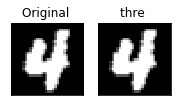

True y= [5.]


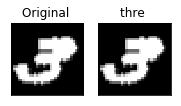

True y= [9.]


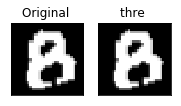

True y= [0.]


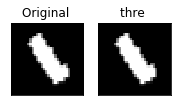

True y= [9.]


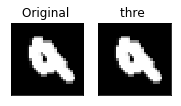

True y= [6.]


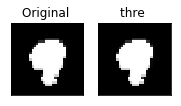

True y= [3.]


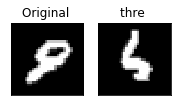

True y= [5.]


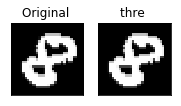

True y= [3.]


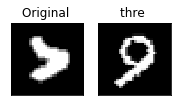

True y= [4.]


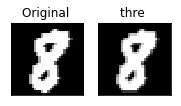

True y= [7.]


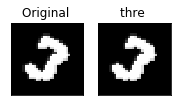

True y= [1.]


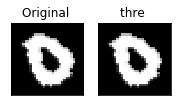

True y= [7.]


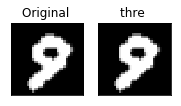

True y= [7.]


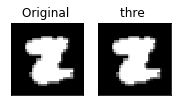

True y= [0.]


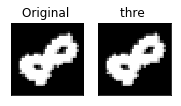

True y= [4.]


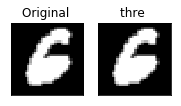

True y= [6.]


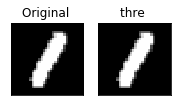

True y= [3.]


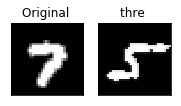

True y= [4.]


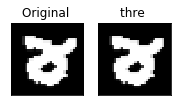

True y= [2.]


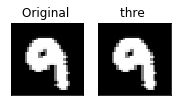

True y= [0.]


In [196]:
compareDSs(xPTest,xPTest_BB,500,20);

## Making an uint8 matrix

In [198]:
def createTrainProcessed(ds,add):
    xPint8 = ds.astype(np.uint8);
    getSizeX(xPint8);
    #compareDatasets(x[:3],xPint8[:3])
    print xPint8.shape
    np.savetxt(add, xPint8.reshape(-1,1024), delimiter=',') 
#createTrainProcessed(xP,'xP.txt'); 
#createTrainProcessed(xPTest,'xPTest.txt');
createTrainProcessed(xP_BB,'xP_BB.txt'); 
createTrainProcessed(xPTest_BB,'xPTest_BB.txt'); 


0.0512
(50000, 32, 32)
0.01024
(10000, 32, 32)


In [ ]:
def garbage():
    plt.subplot(131),plt.imshow(threshOtsu,cmap = 'gray')
    plt.title('Otsu Thresholding'), plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(showContours(threshOtsu),cmap = 'gray')
    plt.title('Otsu contours'), plt.xticks([]), plt.yticks([])
    opening = cv2.morphologyEx(threshOtsu, cv2.MORPH_OPEN, (5,5))
    plt.subplot(133),plt.imshow(opening,cmap = 'gray')
    plt.title('openned'), plt.xticks([]), plt.yticks([])
    plt.show()

    plt.subplot(121),plt.imshow(threshAdaptiveGuassian,cmap = 'gray')
    plt.title('Adaptive Thresholding Guassian'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(showContours(threshAdaptiveGuassian),cmap = 'gray')
    plt.title('Adaptive contours Guassian'), plt.xticks([]), plt.yticks([])
    plt.show()

    plt.subplot(121),plt.imshow(threshAdaptiveMean,cmap = 'gray')
    plt.title('Adaptive Thresholding Mean'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(showContours(threshAdaptiveMean),cmap = 'gray')
    plt.title('Adaptive contours Mean'), plt.xticks([]), plt.yticks([])
    plt.show()
